In [1]:
## plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import stats
from scipy.stats import binned_statistic


## time_frequency
import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

In [35]:
def smooth_signal(p, sz=40, sigma=10):
    '''
        sz :  length of gaussFilter vector
        sigma = 10     
    '''    
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');    
    return pp

In [123]:
# smooth_psd_sz         = 500
# smooth_psd_sigma      = 200
trial_begin           = 0
trial_end             = 2500
filter_data_low_freq  = 4
filter_data_high_freq = 48
smooth_psd_sz         = 15
smooth_psd_sigma      = 2


## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]



all_psd_info = []
all_psd_psd = []
all_psd_freq = []
### Run each session
for sub in range(len(sessions)):
    
    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    idx_trials = trials_markers[sessions[sub]]

    
    ### Loop through this session/patient hippocampal channel
#     for cc in hpc_electrodes[sub]:

    cc = hpc_electrodes[sub][0]
    
    ### Get this channel LFP 
    tmp_lfp = lfp[cc]
    tmp_lfp = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )
    tmp_lfp = mne.filter.filter_data(np.float64(tmp_lfp), fs, 2, 40, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin' )

        
    for trial in range(len(idx_trials)):

        tmp_tmp_lfp = tmp_lfp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
        
        p,f = mne.time_frequency.psd_array_multitaper( tmp_tmp_lfp, fs, fmin=2, fmax=25)        
        pp = smooth_signal(p, sz=smooth_psd_sz, sigma=smooth_psd_sigma)        
        
        
        
        cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
        csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))

        
        all_psd_info.append(  [sub, tmp_density[trial], tmp_speed[trial], cs, csw] )
        all_psd_psd.append( pp )
        all_psd_freq.append( f )
        
        
all_psd_info = np.array(all_psd_info)
all_psd_freq = np.array(all_psd_freq)
all_psd_psd = np.array(all_psd_psd)
all_psd_psd_zs = stats.zscore(all_psd_psd,axis=1)

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 40 Hz
Filter length of 845 samples (1.650 sec) selected
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estim

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 2 - 40 Hz
Filter length of 845 sam

In [209]:
wel_cs = []
for csw in range(4):
    tmp_wel = []
    for sub in range(8):
        idx = np.where(  np.logical_and( all_psd_info[:,0]==sub , all_psd_info[:,4]==csw )    )[0]
        
        tmp_psd_psd = []
        for i in range(all_psd_psd[idx].shape[0]): 
            tmp_psd_psd.append(  all_psd_psd[idx][i] / np.max(all_psd_psd[idx][i]) )
        tmp_psd_psd = np.array(tmp_psd_psd)
        
        tmp_wel.append( np.mean(  tmp_psd_psd,axis=0) )
        
    wel_cs.append( np.mean(tmp_wel,axis=0) )

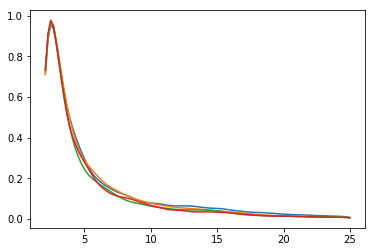

In [210]:
for ii in range(len(wel_cs)):
    plt.plot( all_psd_freq[0], wel_cs[ii] )
    
# plt.xlim(2,9)

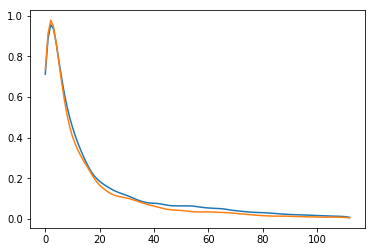

In [218]:
plt.plot(wel_cs[0])
plt.plot(wel_cs[3])